In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score, accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
############################
##### Define Functions #####
############################
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Class 0', 'Class 1'],
                yticklabels=['Class 0', 'Class 1'])
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [3]:
########################
##### Load Dataset #####
########################

df = pd.read_csv("final_data.csv", index_col=0)
# df.head()
# df.isnull().sum()

In [4]:
#############################################
##### Feature selection and engineering #####
#############################################

X_numeric_cols = ['telecommuting', 'has_company_logo', 'has_questions', 'location_has_non_latin',
                  'description_has_non_latin', 'requirements_has_non_latin', 'has_requirements',
                  'has_location', 'has_location_details']
X_text_cols = ['title', 'description_and_requirements']
y_col = ['fraudulent']

df2 = df[X_numeric_cols + X_text_cols + y_col].dropna()

df2["combined_text"] = df2["title"] + " " + df2["description_and_requirements"]

X_numeric = df2[X_numeric_cols]
X_text = df2["combined_text"]
y = df2[y_col].values.ravel()  # Convert to 1D array


In [5]:
# Split the dataset
X_numeric_train, X_numeric_test, X_text_train, X_text_test, y_train, y_test = train_test_split(
    X_numeric, X_text, y, test_size=0.2, random_state=42
)

# Convert text to TF-IDF features so that the neural network can process them
tfidf = TfidfVectorizer(max_features=500, stop_words='english')
X_text_train_tfidf = tfidf.fit_transform(X_text_train)
X_text_test_tfidf = tfidf.transform(X_text_test)

# Combine numeric and text features
X_train_processed = np.hstack([X_numeric_train.values, X_text_train_tfidf.toarray()])
X_test_processed = np.hstack([X_numeric_test.values, X_text_test_tfidf.toarray()])

print(f"Training shape: {X_train_processed.shape}")
print(f"Test shape: {X_test_processed.shape}")


Training shape: (14667, 509)
Test shape: (3667, 509)


In [6]:
def build_model(layer_sizes, input_dim):
    model = models.Sequential()
    model.add(layers.Input(shape=(input_dim,)))
    
    for size in layer_sizes:
        model.add(layers.Dense(size, activation='relu'))
    
    model.add(layers.Dense(1, activation='sigmoid'))  # Binary output
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [13]:
trained_models = {}

# Define different architectures to compare
architectures = {
    "Shallow": [32],
    "Medium": [64, 32],
    "Deep": [128, 64, 32],
    "Wide": [256, 128],
}

# Dictionary to store evaluation results
results = {}

In [14]:
X_train_processed = X_train_processed.astype(np.float32)
X_test_processed = X_test_processed.astype(np.float32)
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

In [15]:
# Train and evaluate each model architecture
results = {}

for name, layer_sizes in architectures.items():
    print(f"\nTraining {name}...")
    
    model = build_model(layer_sizes, X_train_processed.shape[1])
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True) 
     
    history = model.fit(X_train_processed, y_train, validation_split=0.2, 
                        epochs=100, callbacks=[early_stopping], verbose=0)
    
    # Make predictions
    y_pred_proba = model.predict(X_test_processed).flatten()
    y_pred = (y_pred_proba > 0.5).astype(int)
    
    # Calculate classification metrics
    f2 = fbeta_score(y_test, y_pred, beta=2)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    
    results[name] = {"F2": f2, "Accuracy": accuracy, "Precision": precision, "Recall": recall}
    trained_models[name] = model  # store the trained model
    print(f"{name} - F2: {f2:.3f}, Accuracy: {accuracy:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}")


Training Shallow...
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step
Shallow - F2: 0.811, Accuracy: 0.972, Precision: 0.787, Recall: 0.817

Training Medium...
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 509us/step
Medium - F2: 0.785, Accuracy: 0.972, Precision: 0.813, Recall: 0.778

Training Deep...
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step
Deep - F2: 0.805, Accuracy: 0.975, Precision: 0.837, Recall: 0.798

Training Wide...
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 659us/step
Wide - F2: 0.818, Accuracy: 0.978, Precision: 0.870, Recall: 0.805



Model: Shallow
F2 Score:    0.811
Accuracy:    0.972
Precision:   0.787
Recall:      0.817

Model: Medium
F2 Score:    0.785
Accuracy:    0.972
Precision:   0.813
Recall:      0.778

Model: Deep
F2 Score:    0.805
Accuracy:    0.975
Precision:   0.837
Recall:      0.798

Model: Wide
F2 Score:    0.818
Accuracy:    0.978
Precision:   0.870
Recall:      0.805
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step

Classification Report (Wide):
              precision    recall  f1-score   support

   Not Fraud       0.99      0.99      0.99      3410
       Fraud       0.87      0.81      0.84       257

    accuracy                           0.98      3667
   macro avg       0.93      0.90      0.91      3667
weighted avg       0.98      0.98      0.98      3667



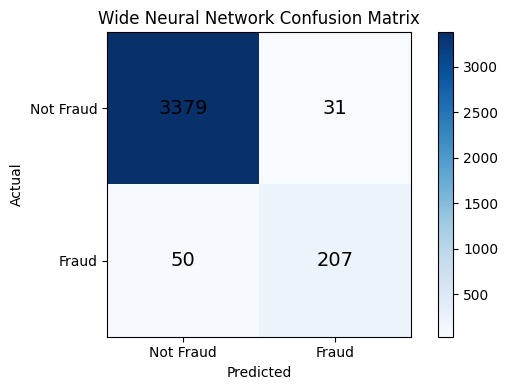

In [ ]:
###########################
##### Display results #####
###########################

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(6, 4))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    for i in range(2):
        for j in range(2):
            plt.text(j, i, cm[i, j], ha='center', va='center', fontsize=14)
    plt.xticks([0, 1], ['Not Fraud', 'Fraud'])
    plt.yticks([0, 1], ['Not Fraud', 'Fraud'])
    plt.tight_layout()
    plt.show()

# Display results for each model
for name, metrics in results.items():
    print(f"\n{'='*50}")
    print(f"Model: {name}")
    print(f"{'='*50}")
    print(f"F2 Score:    {metrics['F2']:.3f}")
    print(f"Accuracy:    {metrics['Accuracy']:.3f}")
    print(f"Precision:   {metrics['Precision']:.3f}")
    print(f"Recall:      {metrics['Recall']:.3f}")

# Find best model by F2 score
best_model_name = max(results, key=lambda x: results[x]['F2'])
best_model = trained_models[best_model_name] 

# Predictions and confusion matrix
y_pred_proba = best_model.predict(X_test_processed).flatten()
y_pred = (y_pred_proba > 0.5).astype(int)

print(f"\nClassification Report ({best_model_name}):")
print(classification_report(y_test.astype(int), y_pred, target_names=['Not Fraud', 'Fraud']))

plot_confusion_matrix(confusion_matrix(y_test.astype(int), y_pred, labels=[0, 1]), 
                      f"{best_model_name} Neural Network Confusion Matrix")

